**Imports**

In [1]:
#!pip install python-dotenv
#!pip install wandb
#!pip install tf-models-official==2.10
#!pip install numpy
#!pip install nibabel
#!pip install matplotlib
#!pip install scikit-image
#!pip install scikit-learn
#!pip install keras
#!pip install tensorflow==2.10
#!pip install opencv-python

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate
import keras
import random
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
import tensorflow_models as tfm
from official.modeling import tf_utils
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, Text
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import cv2
import os
from dotenv import load_dotenv
import wandb
from wandb.keras import WandbCallback
load_dotenv()

**Unpack data** 

*NB: Size is 13.5 GB, code is commented out to prevent accidental unpacking*

In [ ]:
# Data can be downloaded here: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1
# Make sure the file is in the same folder as this project

#import tarfile
#file = tarfile.open('./BraTS2021_Training_Data.tar')

#file.extractall(os.getenv('TRAIN-PATH'))
#file.close()

**Metrics**

In [2]:
# Borrowed from: https://www.kaggle.com/code/malik12345/brain-tumor-detection-using-cnn-model

axis = (0,1,2,3)

def dice_coef(y_true, y_pred, epsilon=0.00001):
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_healthy(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,0] * y_pred[0,:,:,:,0]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,0])) + K.sum(K.square(y_pred[0,:,:,:,0])) + epsilon)

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)

 
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=axis)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=axis)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=axis)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=axis)
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)), axis=axis)
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)), axis=axis)
    return true_negatives / (possible_negatives + K.epsilon())

**Data constants**

In [18]:
IMG_SIZE=120 # Originally 240x240, we reduce this to reduce memory usage
SLICES=128 # Originally 155, reduced for same reason. Must be a power of 2 (or at least divisible by 2, 3 times)
SLICES_START=13 # We skip the first (and the last) few slices as they should contain less information
BATCH_SIZE=1
CHANNELS=4
DATA_AUG=False # Enables data augmentation
DATA_AUG_FACTOR=0 # If we have n data elements, we will have DATA_AUG_FACTOR*n data elements to train on

TRAIN_DATASET_PATH = os.getenv('TRAIN-PATH')

**Data generation**

In [19]:
def RandomBrightness(X, y):
  X = tf.image.stateless_random_brightness(X, 0.2, seed=(1,2)).numpy()
  y = tf.image.stateless_random_brightness(y, 0.2, seed=(1,2)).numpy()
  return X, y

def RandomRotate(X, y):
    r = random.randint(0,3)
    # rotate by 90 degrees times random r
    X = np.rot90(X, k=r)
    y = np.rot90(y, k=r)
    return X, y 
    
def AugmentData(X, y):
  X, y = RandomRotate(X, y)
  X, y = RandomBrightness(X, y)
  return X, y

# Some of the data generation was borrowed from: https://www.kaggle.com/code/malik12345/brain-tumor-detection-using-cnn-model
  
data_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

data_ids = pathListIntoIds(data_directories); 

    
train_and_test_ids, val_ids = train_test_split(data_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_and_test_ids,test_size=0.2)


keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = BATCH_SIZE, n_channels = CHANNELS, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        # Initialization
        X = np.zeros((self.batch_size*SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*SLICES, IMG_SIZE, IMG_SIZE))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()   
            
            data_path = os.path.join(case_path, f'{i}_t1.nii.gz');
            t1 = nib.load(data_path).get_fdata()       

            data_path = os.path.join(case_path, f'{i}_t2.nii.gz');
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            # resize images to specified dimensions and insert into X and y
            for j in range(SLICES):
                X[j+(SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))
                X[j+(SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))
                X[j+(SLICES*c),:,:,2] = cv2.resize(t1[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))
                X[j+(SLICES*c),:,:,3] = cv2.resize(t2[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))                
                
                y[j +SLICES*c,:,:] = cv2.resize(seg[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))

        if DATA_AUG: X, y = AugmentData(X, y)

        X = X.reshape(1,SLICES,IMG_SIZE,IMG_SIZE, CHANNELS)
        y = y.reshape(1,SLICES,IMG_SIZE,IMG_SIZE)
        # Generate masks
        y = tf.one_hot(y, 4);

        # Avoid dividing by zero - return early
        if np.max(X) == 0.0:
          return np.zeros(X.shape), y

        return X/np.max(X), y
        
training_generator = DataGenerator(train_ids*DATA_AUG_FACTOR) if DATA_AUG else DataGenerator(train_ids) 
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Baseline model**

In [5]:
def unet_3d_conv(layer, filters):
    layer = Conv3D(filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    return layer


def unet_3d(input_img):
    c1 = unet_3d_conv(input_img, 8)
    c2 = unet_3d_conv(c1, 16)
    
    c3 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(c2)
    

    c4 = unet_3d_conv(c3, 16)
    c5 = unet_3d_conv(c4, 32)
    c6 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(c5)

    c7 = unet_3d_conv(c6, 32)
    c8 = unet_3d_conv(c7, 64)
    c9 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(c8)

    c10 = unet_3d_conv(c9, 64)
    c11 = unet_3d_conv(c10, 128)
    c12 = UpSampling3D(2)(c11)

    c13 = concatenate([c8, c12])
    c14 = unet_3d_conv(c13, 64)
    c15 = unet_3d_conv(c14, 64)
    c16 = UpSampling3D(2)(c15)

    c17 = concatenate([c5, c16])
    c18 = unet_3d_conv(c17, 32)
    c19 = unet_3d_conv(c18, 32)
    c20 = UpSampling3D(2)(c19)

    c21 = concatenate([c2, c20])
    c22 = unet_3d_conv(c21, 16)
    c23 = unet_3d_conv(c22, 16)
    c24 = Conv3D(4, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(c23)
    c25 = Activation('softmax')(c24)


    model = Model(inputs=input_img, outputs=c25)
    return model 


input_layer = Input((SLICES, IMG_SIZE, IMG_SIZE, CHANNELS))
model = unet_3d(input_layer) 

**Train and test (baseline) model**

In [ ]:
LR = 0.01
EPOCHS = 20
SAVE_MODEL = False # Whether to save the model after training

wandb.init(project="BraTS2021", entity="vj-dl")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "img_size": IMG_SIZE, 
  "slices": SLICES
}

model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR), loss="categorical_crossentropy", metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing, dice_coef_healthy])
model.summary()
model.fit(training_generator, epochs=EPOCHS, validation_data=valid_generator, callbacks=[WandbCallback()])
if SAVE_MODEL:
  model.save("baseline_model.h5")


**Reconstruct model and test it**

In [ ]:
reconstructed_model = keras.models.load_model("baseline_model.h5", custom_objects={"dice_coef":dice_coef, 
                                                                                "precision":precision, 
                                                                                "sensitivity":sensitivity, 
                                                                                "specificity":specificity,
                                                                                "dice_coef_necrotic":dice_coef_necrotic, 
                                                                                "dice_coef_edema":dice_coef_edema, 
                                                                                "dice_coef_enhancing":dice_coef_enhancing,
                                                                                "dice_coef_healthy": dice_coef_healthy})
reconstructed_model.evaluate(test_generator)

**Evaluate on test data**

In [ ]:
model.evaluate(test_generator)

**Callbacks for improved model**

In [6]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_dice_coef', min_delta=0,
                               patience=5, verbose=1, mode='max'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1, mode='max')
    ]

**Improved model definition**

In [7]:
def unet_3d_conv(layer, filters):
    layer = Conv3D(filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    return layer


def unet_3d(input_img):
    c1 = unet_3d_conv(input_img, 8)
    c2 = unet_3d_conv(c1, 16)
    
    c3 = Conv3D(16, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(c2) # Use convolution instead of max pool
    

    c4 = unet_3d_conv(c3, 16)
    c5 = unet_3d_conv(c4, 32)
    c6 = Conv3D(32, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(c5)

    c7 = unet_3d_conv(c6, 32)
    c8 = unet_3d_conv(c7, 64)
    c9 = Conv3D(64, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(c8)

    c10 = unet_3d_conv(c9, 64)
    c11 = unet_3d_conv(c10, 128)
    c12 = Conv3DTranspose(128, kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c11) # Use Transpose instead of UpSampling, kernel size should be divisble by stride

    c13 = concatenate([c8, c12])
    c14 = unet_3d_conv(c13, 64)
    c15 = unet_3d_conv(c14, 64)
    c16 = Conv3DTranspose(64, kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c15)

    c17 = concatenate([c5, c16])
    c18 = unet_3d_conv(c17, 32)
    c19 = unet_3d_conv(c18, 32)
    c20 = Conv3DTranspose(32, kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c19)

    c21 = concatenate([c2, c20])
    c22 = unet_3d_conv(c21, 16)
    c23 = unet_3d_conv(c22, 16)
    c24 = Conv3D(4, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(c23)
    c25 = Activation('softmax')(c24)


    model = Model(inputs=input_img, outputs=c25)
    return model 


input_layer = Input((SLICES, IMG_SIZE, IMG_SIZE, CHANNELS))
improved_model = unet_3d(input_layer) 
improved_model.summary()

**Train and test improved model**

In [ ]:
LR = 0.001
EPOCHS = 20
SAVE_MODEL = False # Whether to save the model after training

wandb.init(project="BraTS2021", entity="vj-dl")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "img_size": IMG_SIZE, 
  "slices": SLICES
}

improved_model.compile(optimizer=keras.optimizers.Nadam(learning_rate=LR), loss="categorical_crossentropy", metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing, dice_coef_healthy])
improved_model.fit(training_generator, epochs=EPOCHS, validation_data=valid_generator, callbacks=[callbacks, WandbCallback()])
if SAVE_MODEL: improved_model.save("dataaug_improved_model.h5") if DATA_AUG else improved_model.save("improved_model.h5")


**Evaluate improved model**

In [ ]:
improved_model.evaluate(test_generator)

**Reconstruct saved model and evaluate it**

In [20]:
reconstructed_model = keras.models.load_model("improved_model.h5", custom_objects={"dice_coef":dice_coef, 
                                                                                "precision":precision, 
                                                                                "sensitivity":sensitivity, 
                                                                                "specificity":specificity,
                                                                                "dice_coef_necrotic":dice_coef_necrotic, 
                                                                                "dice_coef_edema":dice_coef_edema, 
                                                                                "dice_coef_enhancing":dice_coef_enhancing,
                                                                                "dice_coef_healthy": dice_coef_healthy})
reconstructed_model.evaluate(test_generator)

**Plotting**

1/1 [==============================] - 0s 69ms/step


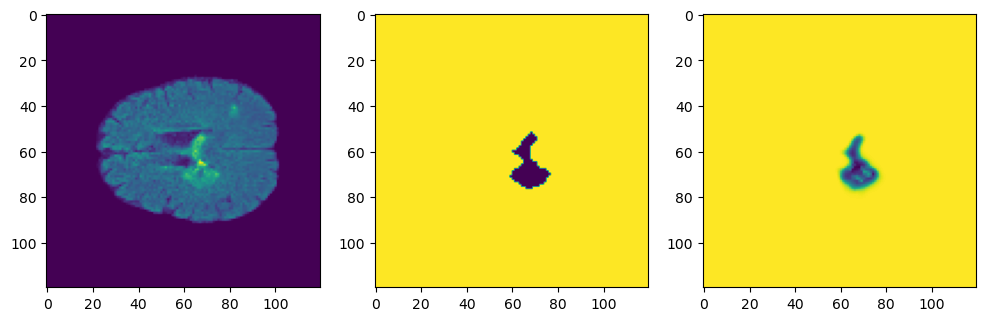

In [22]:
# Get some element (i.e. a 3D scan) from test generator
img1 = test_generator[68]


# get the data of the scan, first 0 is X from (X, y), next 0 is from the batch (which only has one element)
data = img1[0][0]

# Get the ground truth of the training image above (i.e. y from (X, y))
segmentation = img1[1][0]


prediction = reconstructed_model.predict(img1[0]) # predict segmentation
prediction = prediction[0] # get first in batch (i.e. the only element)

# [70,:,:,0] is slice 70. 0 is the FLAIR channel for the training data.
# [70,:,:,0] is slice 70. 0 is the healthy tissue for the masks.

_, axs = plt.subplots(1, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip([data[80,:,:,0], segmentation[80, :, :, 0], prediction[80, :, :, 0]], axs):
    ax.imshow(img)
plt.show()

**Reverse blocks for RevNet model**

In [8]:
# Modifications to tensorflow model garden classes:

class ResidualInner(tf.keras.layers.Layer):
  """Creates a single inner block of a residual.
  This corresponds to `F`/`G` functions in the RevNet paper:
  Aidan N. Gomez, Mengye Ren, Raquel Urtasun, Roger B. Grosse.
  The Reversible Residual Network: Backpropagation Without Storing Activations.
  (https://arxiv.org/pdf/1707.04585.pdf)
  """

  def __init__(
      self,
      filters: int,
      strides: int,
      kernel_initializer: Union[str, Callable[
          ..., tf.keras.initializers.Initializer]] = 'VarianceScaling',
      kernel_regularizer: Optional[tf.keras.regularizers.Regularizer] = None,
      activation: Union[str, Callable[..., tf.Tensor]] = 'relu',
      use_sync_bn: bool = False,
      norm_momentum: float = 0.99,
      norm_epsilon: float = 0.001,
      batch_norm_first: bool = True,
      **kwargs):
    """Initializes a ResidualInner.
    Args:
      filters: An `int` of output filter size.
      strides: An `int` of stride size for convolution for the residual block.
      kernel_initializer: A `str` or `tf.keras.initializers.Initializer`
        instance for convolutional layers.
      kernel_regularizer: A `tf.keras.regularizers.Regularizer` for Conv2D.
      activation: A `str` or `callable` instance of the activation function.
      use_sync_bn: A `bool`. If True, use synchronized batch normalization.
      norm_momentum: A `float` of normalization momentum for the moving average.
      norm_epsilon: A `float` added to variance to avoid dividing by zero.
      batch_norm_first: A `bool` of whether to apply activation and batch norm
        before conv.
      **kwargs: Additional keyword arguments to be passed.
    """
    super(ResidualInner, self).__init__(**kwargs)

    self.strides = strides
    self.filters = filters
    self._kernel_initializer = tf.keras.initializers.get(kernel_initializer)
    self._kernel_regularizer = kernel_regularizer
    self._activation = tf.keras.activations.get(activation)
    self._use_sync_bn = use_sync_bn
    self._norm_momentum = norm_momentum
    self._norm_epsilon = norm_epsilon
    self._batch_norm_first = batch_norm_first

    if use_sync_bn:
      self._norm = tf.keras.layers.experimental.SyncBatchNormalization
    else:
      self._norm = tf.keras.layers.BatchNormalization

    if tf.keras.backend.image_data_format() == 'channels_last':
      self._bn_axis = -1
    else:
      self._bn_axis = 1
    self._activation_fn = tf_utils.get_activation(activation)

  def build(self, input_shape: tf.TensorShape):
    if self._batch_norm_first:
      self._batch_norm_0 = self._norm(
          axis=self._bn_axis,
          momentum=self._norm_momentum,
          epsilon=self._norm_epsilon)

    self._batch_norm_1 = self._norm(
        axis=self._bn_axis,
        momentum=self._norm_momentum,
        epsilon=self._norm_epsilon)

    self._conv3d_2 = Conv3D(
        filters=self.filters,
        kernel_size=3,
        strides=1,
        use_bias=False,
        padding='same',
        kernel_initializer=tf_utils.clone_initializer(self._kernel_initializer),
        kernel_regularizer=self._kernel_regularizer)

    super(ResidualInner, self).build(input_shape)

  def get_config(self) -> Dict[str, Any]:
    config = {
        'filters': self.filters,
        'strides': self.strides,
        'kernel_initializer': self._kernel_initializer,
        'kernel_regularizer': self._kernel_regularizer,
        'activation': self._activation,
        'use_sync_bn': self._use_sync_bn,
        'norm_momentum': self._norm_momentum,
        'norm_epsilon': self._norm_epsilon,
        'batch_norm_first': self._batch_norm_first,
    }
    base_config = super(ResidualInner, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def call(self,
           inputs: tf.Tensor,
           training: Optional[bool] = None) -> tf.Tensor:
    x = inputs

    x = self._batch_norm_1(x, training=training)
    x = self._conv3d_2(x)
    x = self._activation_fn(x)
    return x
 
class ReversibleLayer(tf.keras.layers.Layer):
  """Creates a reversible layer.
  Computes y1 = x1 + f(x2), y2 = x2 + g(y1), where f and g can be arbitrary
  layers that are stateless, which in this case are `ResidualInner` layers.
  """

  def __init__(self,
               f: tf.keras.layers.Layer,
               g: tf.keras.layers.Layer,
               manual_grads: bool = True,
               **kwargs):
    """Initializes a ReversibleLayer.
    Args:
      f: A `tf.keras.layers.Layer` instance of `f` inner block referred to in
        paper. Each reversible layer consists of two inner functions. For
        example, in RevNet the reversible residual consists of two f/g inner
        (bottleneck) residual functions. Where the input to the reversible layer
        is x, the input gets partitioned in the channel dimension and the
        forward pass follows (eq8): x = [x1; x2], z1 = x1 + f(x2), y2 = x2 +
        g(z1), y1 = stop_gradient(z1).
      g: A `tf.keras.layers.Layer` instance of `g` inner block referred to in
        paper. Detailed explanation same as above as `f` arg.
      manual_grads: A `bool` [Testing Only] of whether to manually take
        gradients as in Algorithm 1 or defer to autograd.
      **kwargs: Additional keyword arguments to be passed.
    """
    super(ReversibleLayer, self).__init__(**kwargs)

    self._f = f
    self._g = g
    self._manual_grads = manual_grads

    if tf.keras.backend.image_data_format() == 'channels_last':
      self._axis = -1
    else:
      self._axis = 1

  def get_config(self) -> Dict[str, Any]:
    config = {
        'f': self._f,
        'g': self._g,
        'manual_grads': self._manual_grads,
    }
    base_config = super(ReversibleLayer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def _ckpt_non_trainable_vars(self):
    self._f_non_trainable_vars = [
        v.read_value() for v in self._f.non_trainable_variables
    ]
    self._g_non_trainable_vars = [
        v.read_value() for v in self._g.non_trainable_variables
    ]

  def _load_ckpt_non_trainable_vars(self):
    for v, v_chkpt in zip(self._f.non_trainable_variables,
                          self._f_non_trainable_vars):
      v.assign(v_chkpt)
    for v, v_chkpt in zip(self._g.non_trainable_variables,
                          self._g_non_trainable_vars):
      v.assign(v_chkpt)

  def call(self,
           inputs: tf.Tensor,
           training: Optional[bool] = None) -> tf.Tensor:

    @tf.custom_gradient
    def reversible(
        x: tf.Tensor
    ) -> Tuple[tf.Tensor, Callable[[Any], Tuple[List[tf.Tensor],
                                                List[tf.Tensor]]]]:
      """Implements Algorithm 1 in the RevNet paper.
         Aidan N. Gomez, Mengye Ren, Raquel Urtasun, Roger B. Grosse.
         The Reversible Residual Network: Backpropagation Without Storing
         Activations.
         (https://arxiv.org/pdf/1707.04585.pdf)
      Args:
        x: An input `tf.Tensor.
      Returns:
        y: The output [y1; y2] in Algorithm 1.
        grad_fn: A callable function that computes the gradients.
      """
      with tf.GradientTape() as fwdtape:
        fwdtape.watch(x)
        x1, x2 = tf.split(x, num_or_size_splits=2, axis=self._axis)
        f_x2 = self._f(x2, training=training)
        z1 = f_x2 + x1
        g_z1 = self._g(z1, training=training)
        y2 = x2 + g_z1

        # Equation 8: https://arxiv.org/pdf/1707.04585.pdf
        # Decouple y1 and z1 so that their derivatives are different.
        y1 = tf.identity(z1)
        y = tf.concat([y1, y2], axis=self._axis)

        irreversible = ((self._f.strides != 1 or self._g.strides != 1) or
                        (y.shape[self._axis] != inputs.shape[self._axis]))

        # Checkpointing moving mean/variance for batch normalization layers
        # as they shouldn't be updated during the custom gradient pass of f/g.
        self._ckpt_non_trainable_vars()

      def grad_fn(
          dy: tf.Tensor,
          variables: Optional[List[tf.Variable]] = None,
      ) -> Tuple[List[tf.Tensor], List[tf.Tensor]]:
        """Given dy calculate (dy/dx)|_{x_{input}} using f/g."""
        if irreversible or not self._manual_grads:
          grads_combined = fwdtape.gradient(
              y, [x] + variables, output_gradients=dy)
          dx = grads_combined[0]
          grad_vars = grads_combined[1:]
        else:
          y1_nograd = tf.stop_gradient(y1)
          y2_nograd = tf.stop_gradient(y2)
          dy1, dy2 = tf.split(dy, num_or_size_splits=2, axis=self._axis)

          # Index mapping from self.f/g.trainable_variables to grad_fn
          # input `variables` kwarg so that we can reorder dwf + dwg
          # variable gradient list to match `variables` order.
          f_var_refs = [v.ref() for v in self._f.trainable_variables]
          g_var_refs = [v.ref() for v in self._g.trainable_variables]
          fg_var_refs = f_var_refs + g_var_refs
          self_to_var_index = [fg_var_refs.index(v.ref()) for v in variables]

          # Algorithm 1 in paper (line # documented in-line)
          z1 = y1_nograd  # line 2
          with tf.GradientTape() as gtape:
            gtape.watch(z1)
            g_z1 = self._g(z1, training=training)
          x2 = y2_nograd - g_z1  # line 3

          with tf.GradientTape() as ftape:
            ftape.watch(x2)
            f_x2 = self._f(x2, training=training)
          x1 = z1 - f_x2  # pylint: disable=unused-variable      # line 4

          # Compute gradients
          g_grads_combined = gtape.gradient(
              g_z1, [z1] + self._g.trainable_variables, output_gradients=dy2)
          dz1 = dy1 + g_grads_combined[0]  # line 5
          dwg = g_grads_combined[1:]  # line 9

          f_grads_combined = ftape.gradient(
              f_x2, [x2] + self._f.trainable_variables, output_gradients=dz1)
          dx2 = dy2 + f_grads_combined[0]  # line 6
          dwf = f_grads_combined[1:]  # line 8
          dx1 = dz1  # line 7

          # Pack the input and variable gradients.
          dx = tf.concat([dx1, dx2], axis=self._axis)
          grad_vars = dwf + dwg
          # Reorder gradients (trainable_variables to variables kwarg order)
          grad_vars = [grad_vars[i] for i in self_to_var_index]

          # Restore batch normalization moving mean/variance for correctness.
          self._load_ckpt_non_trainable_vars()

        return dx, grad_vars  # grad_fn end

      return y, grad_fn  # reversible end

    activations = reversible(inputs)
    return activations

**RevNet model: Larger IMG_SIZE (remember to run data generation cell again)**

In [13]:
IMG_SIZE=240

**RevNet model definition**

In [15]:
def unet_3d_conv(layer, filters):
    layer = Conv3D(filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    return layer


def unet_3d(input_img):
    c1 = Conv3D(16, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(input_img)
    
    resF = ResidualInner(filters=8, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=8, strides=1, batch_norm_first=False)
    rev1 = ReversibleLayer(resF, resG)(c1)
    
    m1 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(rev1)
    c2 = Conv3D(32, kernel_size=(1,1,1), strides=(1,1,1),padding='same')(m1)
    
    resF = ResidualInner(filters=16, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=16, strides=1, batch_norm_first=False)
    rev2 = ReversibleLayer(resF, resG)(c2)
    
    m2 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(rev2)
    c3 = Conv3D(64, kernel_size=(1,1,1), strides=(1,1,1),padding='same')(m2)
    
    resF = ResidualInner(filters=32, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=32, strides=1, batch_norm_first=False)
    rev3 = ReversibleLayer(resF, resG)(c3)
    
    m3 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(rev3)
    c4 = Conv3D(128, kernel_size=(1,1,1), strides=(1,1,1),padding='same')(m3)
    
    resF = ResidualInner(filters=64, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=64, strides=1, batch_norm_first=False)
    rev4 = ReversibleLayer(resF, resG)(c4)
    
    m4 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(rev4)
    c5 = Conv3D(256, kernel_size=(1,1,1), strides=(1,1,1),padding='same')(m4)
    
    resF = ResidualInner(filters=128, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=128, strides=1, batch_norm_first=False)
    rev5 = ReversibleLayer(resF, resG)(c5)
    
    resF = ResidualInner(filters=128, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=128, strides=1, batch_norm_first=False)
    rev6 = ReversibleLayer(resF, resG)(rev5)
    
    upConv1 = Conv3D(128, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(rev6)
    upSample1 = UpSampling3D(2)(upConv1)
    
    cat1 = concatenate([rev4, upSample1])
    
    resF = ResidualInner(filters=128, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=128, strides=1, batch_norm_first=False)
    rev7 = ReversibleLayer(resF, resG)(cat1)
    
    upConv2 = Conv3D(64, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(rev7)
    upSample2 = UpSampling3D(2)(upConv2)
    
    cat2 = concatenate([rev3, upSample2])
    
    resF = ResidualInner(filters=64, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=64, strides=1, batch_norm_first=False)
    rev8 = ReversibleLayer(resF, resG)(cat2)
    
    upConv3 = Conv3D(32, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(rev8)
    upSample3 = UpSampling3D(2)(upConv3)
    
    cat3 = concatenate([rev2, upSample3])
    
    resF = ResidualInner(filters=32, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=32, strides=1, batch_norm_first=False)
    rev9 = ReversibleLayer(resF, resG)(cat3)
    
    upConv4 = Conv3D(16, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(rev9)
    upSample4 = UpSampling3D(2)(upConv4)
    
    cat4 = concatenate([rev1, upSample4])
    
    resF = ResidualInner(filters=16, strides=1, batch_norm_first=False)
    resG = ResidualInner(filters=16, strides=1, batch_norm_first=False)
    rev10 = ReversibleLayer(resF, resG)(cat4)
    
    final_conv = Conv3D(4, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(rev10)
    output = Activation('softmax')(final_conv)


    model = Model(inputs=input_img, outputs=output)
    return model 


input_layer = Input((SLICES, IMG_SIZE, IMG_SIZE, CHANNELS))
rev_model = unet_3d(input_layer) 
rev_model.summary()

**Train and test memory efficient model**

In [ ]:
LR = 0.01
EPOCHS = 20
SAVE_MODEL = False # Whether to save the model after training

wandb.init(project="BraTS2021", entity="vj-dl")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "img_size": IMG_SIZE, 
  "slices": SLICES
}

rev_model.compile(optimizer=keras.optimizers.Nadam(learning_rate=LR), loss="categorical_crossentropy", metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing, dice_coef_healthy])
rev_model.fit(training_generator, epochs=EPOCHS, validation_data=valid_generator, callbacks=[callbacks, WandbCallback(save_model=False)])

if SAVE_MODEL: rev_model.save("rev_model.h5")

